# Desafío para hacerla de jamón

Una tribu pacífica de la isla tiene un concurso legendario de jamones. 
El jurado es muy longevo y este año ha perdido a más de la mitad de sus miembros. La tribu te ha enviado una base de datos (`score_de_jamonosidad.csv`) de los últimos concursos. En esta base de datos se enlistan distintos especímenes de jamones con la calificación que el jurado otorgó a cada uno. También has recibido una base de datos de jamones no calificados (`jamones_por_calificar.csv`) que deberás calificar, honrando el espíritu del jurado.

* <a href="#exploration">Explora tus datasets.</a>
* <a href="#explica">A. Explica la idea general de tu solución con dibujos, diagramas, videos, legos, bolitas
de plastilina, etc.</a>
* <a href="#implementa">B. Implementa tu solución explicando los pasos.</a>
* <a href="#completa">C. Completa el archivo jamones_por_calificar.csv con tu veredicto.</a>

<a id='exploration'></a>
## Explorar data

In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('datasets/score_de_jamonosidad.csv')
test = pd.read_csv('datasets/jamones_por_calificar.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 5 columns):
jamon    28 non-null int64
score    28 non-null int64
v1       28 non-null int64
v2       28 non-null float64
v3       28 non-null int64
dtypes: float64(1), int64(4)
memory usage: 1.2 KB


In [4]:
train.describe()

,jamon,score,v1,v2,v3
count,28.000000,28.000000,28.000000,28.000000,28.000000
mean,14.500000,6.964286,2127.214286,58.296429,2132.964286
std,8.225975,3.479912,499.116134,5.457342,367.711288
min,1.000000,0.000000,1414.000000,43.800000,1457.000000
25%,7.750000,4.000000,1714.000000,54.775000,1887.750000
50%,14.500000,6.500000,2106.000000,58.850000,2062.500000
75%,21.250000,10.000000,2474.250000,61.100000,2427.250000
max,28.000000,13.000000,2929.000000,68.500000,2876.000000


**Checar tendencias**

Se puede apreciar una ligera tendencia en cada una de las variables.

(<matplotlib.axes._subplots.AxesSubplot at 0x7f6d1058cfd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6d0e221a58>)

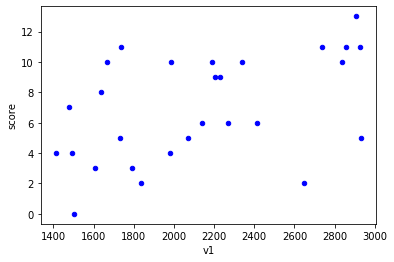

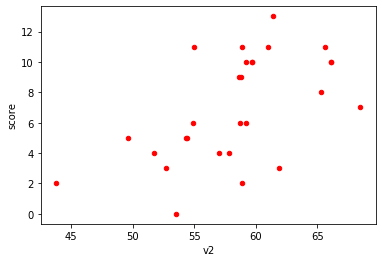

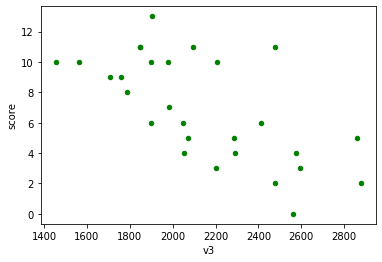

In [5]:
%matplotlib inline

ax1 = train[['v1', 'score']].plot.scatter(x='v1', y='score', c='blue')
ax2 = train[['v2', 'score']].plot.scatter(x='v2', y='score', c='red')
ax3 = train[['v3', 'score']].plot.scatter(x='v3', y='score', c='green')
ax1, ax2, ax3

**Checando correlaciones**

V2 y V3 parecen estar mas correlacionadas entre sí que con el score. Podría funcionar solo tomar una de las dos, si así fuese me quedaría con V3, ya que su correlación es mayor con el score comparado con V2.

In [6]:
corrs =  train[['score', 'v1', 'v2', 'v3']].corr()
corrs.style.background_gradient(cmap='Greens')

,score,v1,v2,v3
score,1,0.482735,0.557565,-0.658654
v1,0.482735,1,-0.194074,0.0296435
v2,0.557565,-0.194074,1,-0.67986
v3,-0.658654,0.0296435,-0.67986,1


<a id='explica'></a>
## A. Explica la idea general de tu solución con dibujos, diagramas, videos, legos, bolitas de plastilina, etc.

Mi solución consiste en usar una **regresión lineal múltiple**.

Una regresión lineal básicamente trata de ajustar una línea a los datos tratando de minimizar el cuadrado del error.

$Error = \sum_i (Estimacion_i - y_i)^2$, 

donde $Estimacion = \sum_i (mx_i + b)$

La forma en que se minimiza el error es usando derivadas parciales, haciendola igual a 0, ya que la función de error es convexa.

Ejemplo de función convexa del error:

![](https://raw.githubusercontent.com/jfreek/math_animations/master/examples/derivative.gif)

Al hacerla igual a 0 encontramos justo el punto mínimo.

Esta animación que puede explicar regresión lineal visualmente (Aunque en el ejemplo usa gradient descent):

![](https://raw.githubusercontent.com/jfreek/math_animations/master/examples/e3e4.gif)

Después de minimizar el error tenemos un modelo robusto que nos puede ayudar a estimar nuevos valores.
O en otras palabras encontramos los coeficientes y la intersección que nos dieron el resultado de menor error.

Una regresión lineal multiple hace esto pero para cada variable, teniendo una combinación de coeficientes como resultado.

$res = C_1x_1 + C_2x_2 + C_3x_3 + b $

Ahora solo tenemos que sustituir nuevos valores de $x_i$ y podremos tener estimaciones.

<a id='implementa'></a>
## B. Implementa tu solución explicando los pasos.


### Regresión lineal

Me parece buena idea intentar hacer una regresión lineal con todas las variables como primer intento.

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

dep = train['score'].values
ind = train.drop(['score', 'jamon'], axis=1).values.reshape(-1,3)

reg1 = LinearRegression()
reg1.fit(ind, dep)

print('coeffs = ', reg1.coef_)
print('intercept = ', reg1.intercept_)

y = reg1.predict(ind)
print('R^2 = ', r2_score(y, dep))
print('mse = ', mean_squared_error(y, dep))

coeffs =  [ 0.0039765   0.24777098 -0.00389329]
intercept =  -7.634488210072695
R^2 =  0.6892776250117992
mse =  2.7682422993868387


Los coeficientes nos dicen que el valor con mayor peso al hacer una estimación es V2, una unidad de cambio en esta variable afecta 0.24 al resultado. V3 esta aportando de forma negativa como esperabamos.

Veamos qué pasa si quitamos v2, como mencionamos unos pasos arriba.

**Dropping v2**

De acuerdo a las correlaciones V2 esta mas correlacionada con V3 que con el score, por lo tanto veamos que pasa al quitarla.

In [8]:
dep = train['score'].values
ind = train.drop(['score', 'jamon', 'v2'], axis=1).values.reshape(-1,2)

reg2 = LinearRegression()
reg2.fit(ind, dep)

print('coeffs = ', reg2.coef_)
print('intercept = ', reg2.intercept_)

y = reg2.predict(ind)
print('R^2 = ', r2_score(y, dep))
print('mse = ', mean_squared_error(y, dep))

coeffs =  [ 0.00350491 -0.00637434]
intercept =  13.104832998237914
R^2 =  0.5429370028060064
mse =  3.66302615731004


Los resultados en el coeficiente de determinación son diferentes casi por 0.14, y el `mean squared error` nos dice que el primer modelo hace un mejor trabajo, lo cual es consistente con la metrica R^2.

Por lo tanto nos quedaremos con el primer modelo.

<a id='completa'></a>
## C. Completa el archivo jamones_por_calificar.csv con tu veredicto.

In [9]:
ind = test.drop(['score', 'jamon'], axis=1).values.reshape(-1,3)
predictions = reg1.predict(ind)

test['score'] = predictions

In [10]:
test

,jamon,score,v1,v2,v3
0,29,9.230151,2383,59,1857
1,30,3.337671,1598,61,2696
2,31,13.169421,2883,67,1865
3,32,6.777708,2898,56,2822
4,33,8.661536,2877,44,1553
5,34,3.365009,1966,55,2683
6,35,4.829660,1786,66,2823
7,36,10.599623,2813,63,2199
8,37,8.195240,2882,52,2187
9,38,10.042945,2859,49,1498


In [11]:
test.to_csv('soluciones/jamones_por_calificar.csv')